In [2]:
import wandb
import pandas as pd
from utils.utils import plot_confidence_error, expected_calibration_error, calculate_macro_ece, calculate_auroc, calculate_auroc
from utils.utils import extract_texts_and_confidences
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
project_name = "uncertainty-reimplimentation-results"
job_type = "eval"
model = "gpt-4o"
dataset = "HotpotQA"

runs = pd.read_csv("csv/inference.csv")
runs = runs[runs["model"] == model]
runs = runs[runs["dataset"] == dataset]
runs 

,Name,ID,dataset,model,prompt
25,rose-energy-724,gr7ngjjq,HotpotQA,gpt-4o,multistep
32,dainty-valley-734,62vwtwzf,HotpotQA,gpt-4o,top-k
34,sweet-salad-722,4ozhkaeq,HotpotQA,gpt-4o,cot
35,stoic-sound-720,27ttbhgo,HotpotQA,gpt-4o,direct


In [5]:
api = wandb.Api()

tables = []

for _, row in runs.iterrows():
    run_id = row["ID"]
    prompt = row["prompt"]
    artifact = api.artifact(f"{project_name}/run-{run_id}-table:v0")
    table: pd.DataFrame = artifact.get("table").get_dataframe()
    table["prompt"] = prompt
    table["dataset"] = row["dataset"]
    table["model"] = row["model"]
    tables.append(table)

combined_table = pd.concat(tables)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


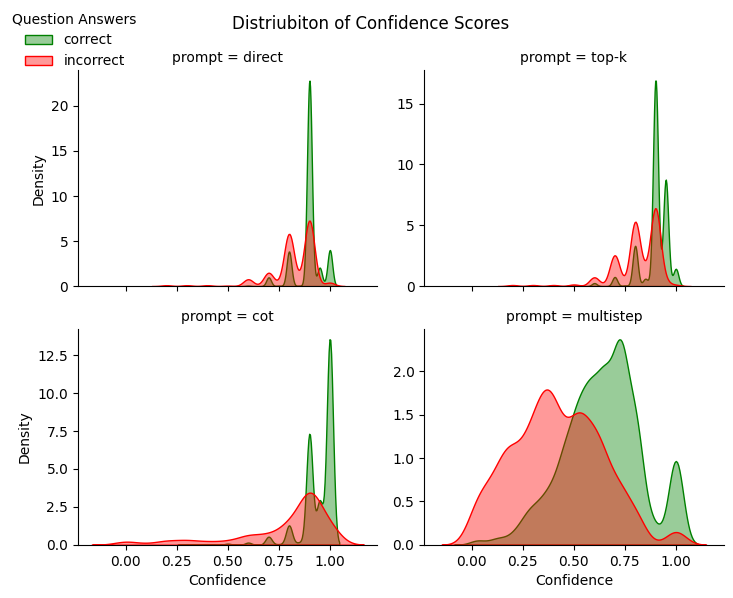

In [53]:
combined_table["label"] = combined_table["gpt_eval"].apply(lambda x: "correct" if x else "incorrect")

order = ["direct",  "top-k","cot", "multistep"]
g = sns.FacetGrid(data=combined_table, col="prompt", hue="label", sharey=False,
              palette={"incorrect":'red',"correct":'green'}, col_order=order,col_wrap=2)
g.map(sns.kdeplot, "confidence", fill=True, alpha=0.4,bw_adjust=0.7)
g.add_legend(title="Question Answers", loc="upper left")
g.set_axis_labels("Confidence", "Density")
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Distriubiton of Confidence Scores')
plt.tight_layout()
plt.savefig("images/conf_density.png")
plt.show()

<Figure size 1000x400 with 0 Axes>

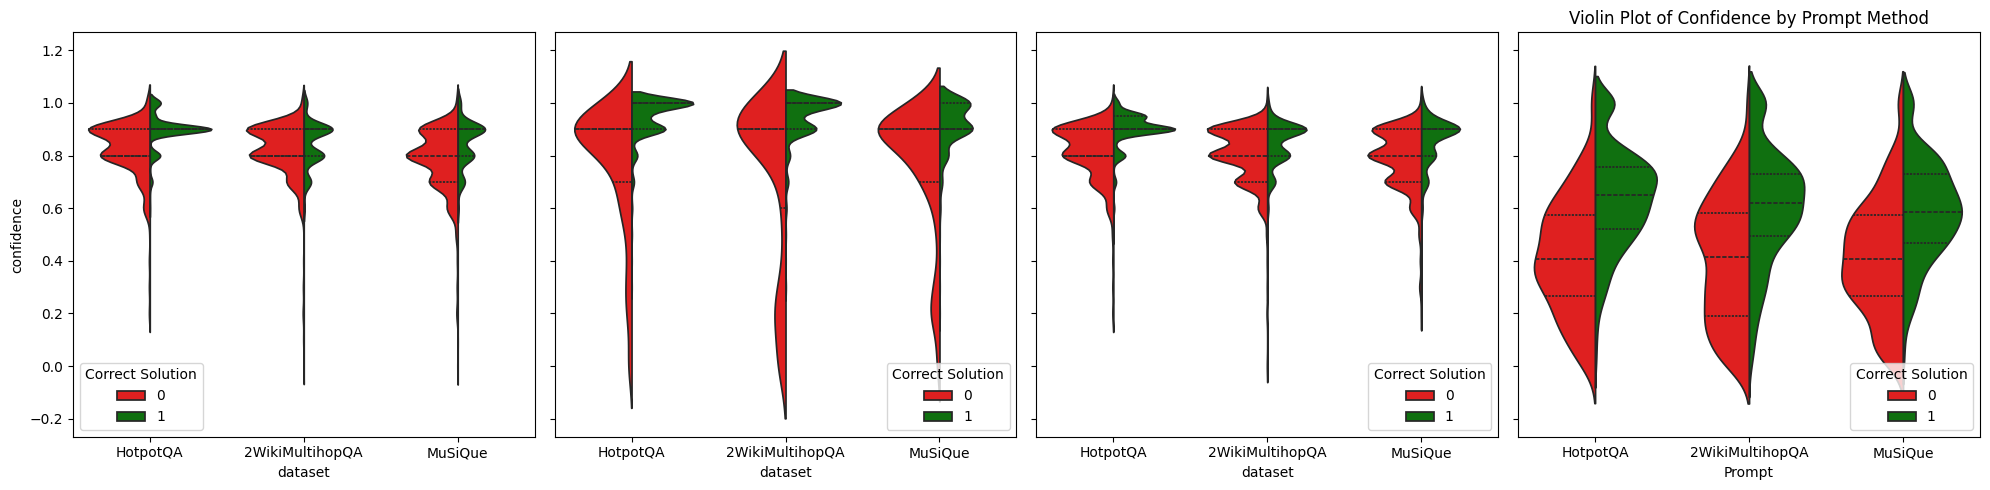

In [48]:
plt.figure(figsize=(10,4))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # sharey=True keeps the y-axis consistent

for ax, prompt in zip(axes, order):
    curr_table = combined_table[combined_table["prompt"] == prompt]

    sns.violinplot(x='dataset', y='confidence', hue='gpt_eval',
        data=curr_table, ax=ax, inner="quarter", palette={1: "green", 0: "red"}, bw_adjust=1,split=True,
        order=["HotpotQA", "2WikiMultihopQA", "MuSiQue"],
    )
    
    ax.legend(title='Correct Solution')
plt.title('Violin Plot of Confidence by Prompt Method')
plt.ylabel('Confidence')
plt.xlabel('Prompt')
plt.tight_layout()
plt.show()

In [8]:
table = combined_table[combined_table["prompt"] == "multistep"]
table["confs"] = table.apply(lambda x: extract_texts_and_confidences(x["response"])[1], axis=1)
table["num_steps"] = table.apply(lambda x: min(len(x["confs"]) - 1, 5), axis=1)

/tmp/ipykernel_153664/722139987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["confs"] = table.apply(lambda x: extract_texts_and_confidences(x["response"])[1], axis=1)
/tmp/ipykernel_153664/722139987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["num_steps"] = table.apply(lambda x: min(len(x["confs"]) - 1, 5), axis=1)


In [11]:
long = []
for _, row in table.iterrows():
    confs = row["confs"]
    for i, conf in enumerate(confs):
        if i < len(confs) -1 and i < 5:
            long.append({"step" : i, "conf" : conf, "em" : row["em"], "gpt_eval" : row["gpt_eval"],"agg_conf" : row["confidence"]})
        
    long.append({"step" : "answer", "conf" : confs[-1], "em" : row["em"],"gpt_eval" : row["gpt_eval"], "agg_conf" : row["confidence"]})

df_long = pd.DataFrame(long)
df_long["label"] = df_long["gpt_eval"].apply(lambda x: "correct" if x else "incorrect")

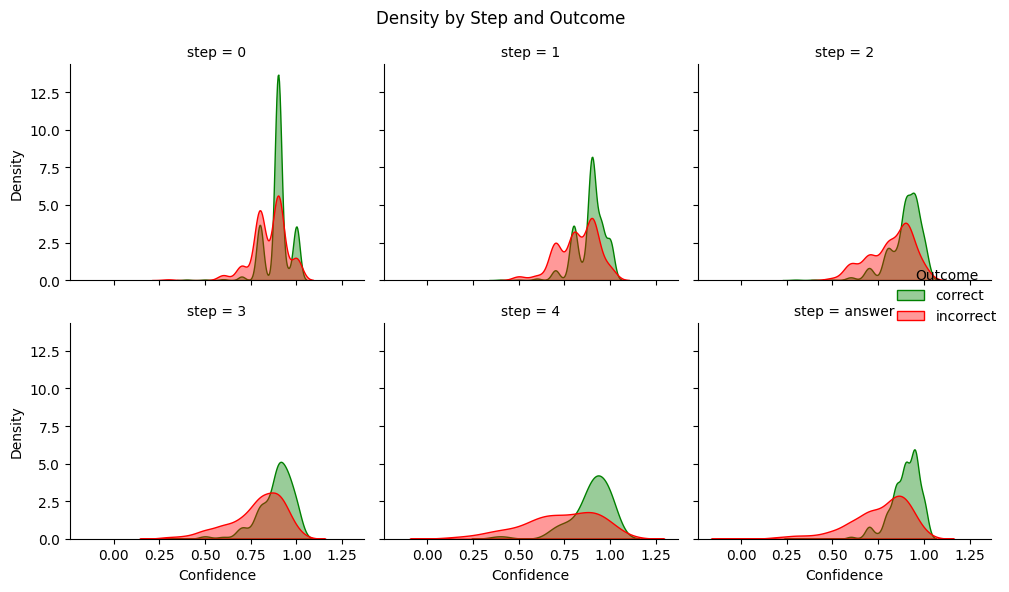

In [12]:
step_order = [0, 1, 2, 3, 4, "answer"]

g = sns.FacetGrid(data=df_long, col="step", hue="label", col_wrap=3, col_order=step_order,
              palette={"correct":'green',"incorrect":'red'})
g.map(sns.kdeplot, "conf", fill=True, alpha=0.4)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.tight_layout()
plt.show()

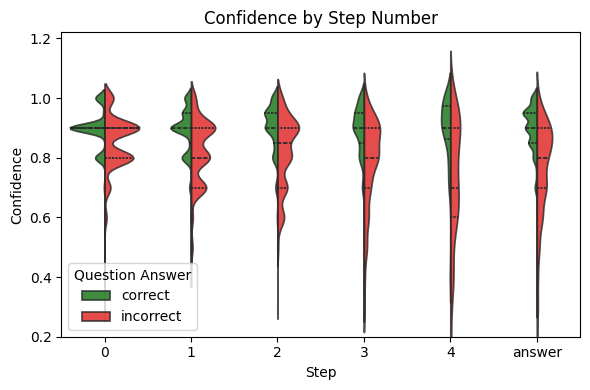

In [47]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 2) Plot
plt.figure(figsize=(6,4))
sns.violinplot(
    x="step", y='conf', hue='label',
    data=df_long, split=True, inner='quartile', palette={"correct": "green", "incorrect": "red"}, alpha=0.8,bw_adjust=0.8, order=step_order,
)
plt.title('Confidence by Step Number')
plt.ylabel('Confidence')
plt.xlabel('Step')
plt.legend(title='Question Answer', loc="lower left")
plt.tight_layout()
plt.ylim(0.2)
plt.savefig("images/steps.png")
plt.show()

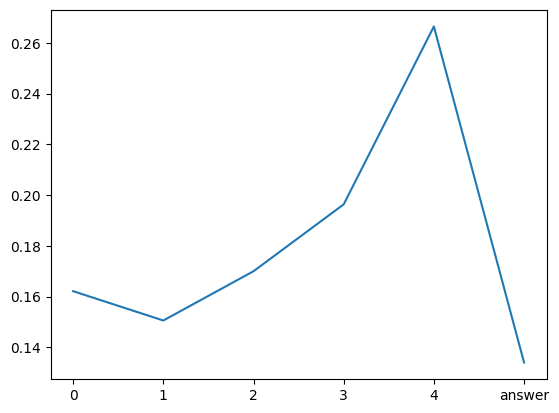

In [40]:
groups = df_long.groupby("step")
df_long["confidence"] = df_long["conf"]

mces = []
labels = []

for label, group in groups:
    mce = expected_calibration_error(group["gpt_eval"], group["confidence"])
    mces.append(mce)
    labels.append(str(label))

plt.plot(labels, mces)



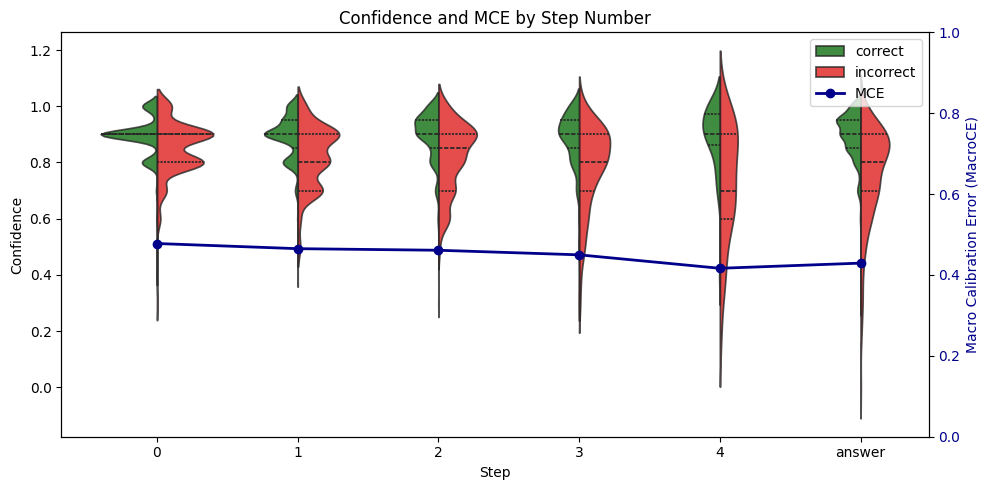

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df_long["confidence"] = df_long["conf"]
groups = df_long.groupby("step")
mces = []
labels = []

for label, group in groups:
    mce = calculate_macro_ece(group, collumn="gpt_eval")
    mces.append(mce)
    labels.append(str(label))

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Violin plot on primary y-axis
sns.violinplot(
    x="step", y="conf", hue="label", data=df_long,
    split=True, inner="quartile", palette={"correct": "green", "incorrect": "red"},
    alpha=0.8, bw_adjust=1, order=step_order, ax=ax1
)

ax1.set_ylabel("Confidence")
ax1.set_xlabel("Step")
#ax1.set_ylim(0.2, 1.0)
ax1.set_title("Confidence and MCE by Step Number")
ax1.legend(title="Question Answer")

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(labels, mces, color="darkblue", marker="o", linestyle="-", linewidth=2, label="MCE")
ax2.set_ylabel("Macro Calibration Error (MacroCE)", color="darkblue")
ax2.tick_params(axis="y", labelcolor="darkblue")
ax2.set_ylim(0.0, 1.0)

# Combine legends (optional)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.tight_layout()
plt.savefig("images/steps_combined.png")
plt.show()

Text(0.5, 1.0, 'Number of Steps Taken')

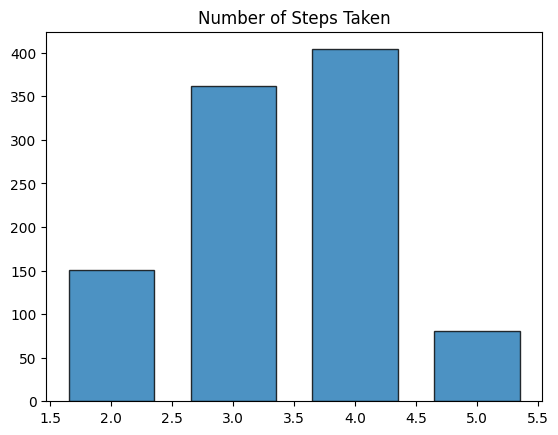

In [126]:
from collections import Counter

cnt = Counter(table["num_steps"])
cnt = sorted(cnt.items(), key=lambda x: x[0])
labels, counts = zip(*cnt)
plt.bar(labels, counts, width=0.7, alpha=0.8, edgecolor = "black")
plt.title("Number of Steps Taken")

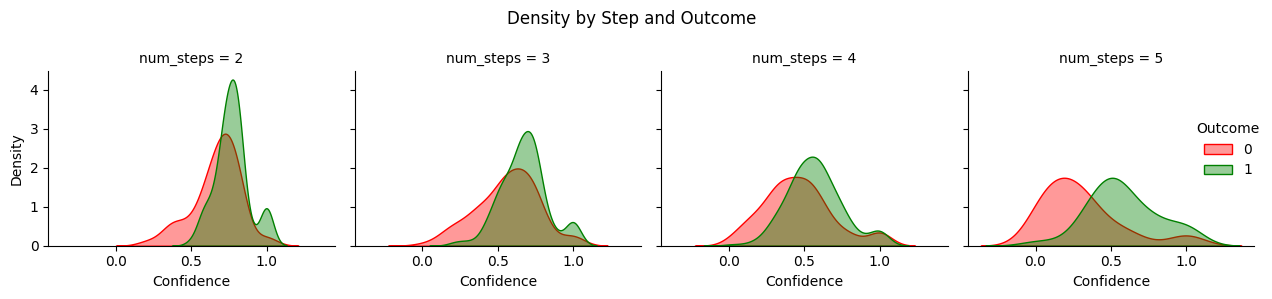

In [94]:
table = table[table["num_steps"] != 1]
g = sns.FacetGrid(data=table, col="num_steps", hue="em", col_wrap=4,
              palette={1:'green',0:'red'})
g.map(sns.kdeplot, "confidence", fill=True, alpha=0.4)
g.add_legend(title="Outcome")
g.set_axis_labels("Confidence", "Density")

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Density by Step and Outcome')
plt.tight_layout()
plt.show()

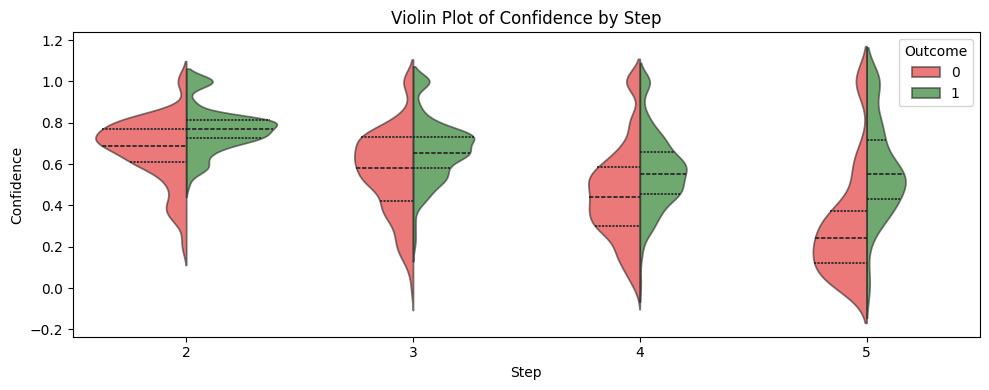

In [95]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 2) Plot
plt.figure(figsize=(10,4))
sns.violinplot(
    x='num_steps', y='confidence', hue='em',
    data=table, split=True, inner='quartile', palette={1: "green", 0: "red"}, alpha=0.6,bw_adjust=0.7
)
plt.title('Violin Plot of Confidence by Step')
plt.ylabel('Confidence')
plt.xlabel('Step')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

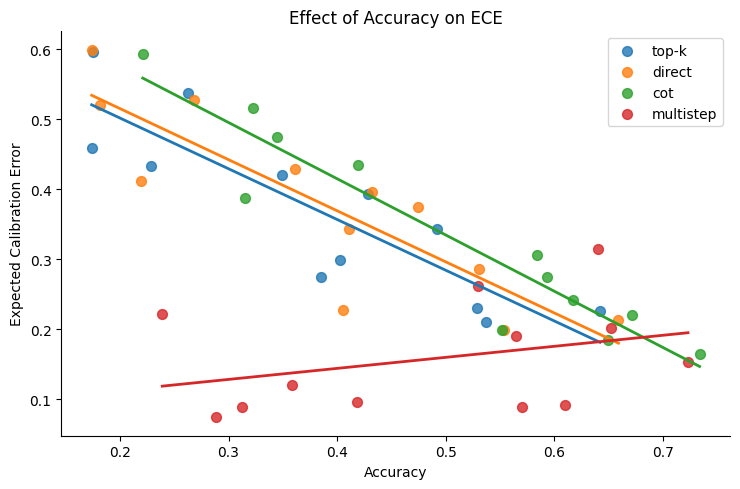

In [3]:
df = pd.read_csv("csv/gpt-eval.csv")

import seaborn as sns
import matplotlib.pyplot as plt
import math


# Plot
sns.lmplot(
    data=df,
    x='acc',
    y='ece',
    hue='prompt',
    ci=None,
    markers='o',
    scatter_kws={'s': 50},
    line_kws={'linewidth': 2},
    height=5,
    aspect=1.5,
    legend=False
)

plt.title("Effect of Accuracy on ECE")
plt.xlabel("Accuracy")
plt.ylabel("Expected Calibration Error")
plt.tight_layout()
plt.legend(loc="upper right")
plt.savefig("images/agg/acc_v_ece.png")
plt.show()